In [ ]:
#скачиваем данные
!gdown --id 16s_VXsqQL5uBshXdhjo9PYzLlvi-5JUe
!gdown --id 145D0SGj-RkGPVmJS_gV_iMB4-4FM2ZoJ

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16s_VXsqQL5uBshXdhjo9PYzLlvi-5JUe
To: /content/test.csv
100% 28.6k/28.6k [00:00<00:00, 29.0MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=145D0SGj-RkGPVmJS_gV_iMB4-4FM2ZoJ
To: /content/train.csv
100% 61.2k/61.2k [00:00<00:00, 42.4MB/s]


In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.6 MB/s eta 0:00:00


In [ ]:
# импортируем библиотеки 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# среднее значение наблюдаемых значений было равно 0, а стандартное отклонение – 1 (MinMaxScaler- чтобы функция находилас между 0 и 1)
from sklearn.preprocessing import StandardScaler
# для кроссвалидации 
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
# анасамбли
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
# на основе бустинга
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# import optuna

Как происходит кроссвалидация

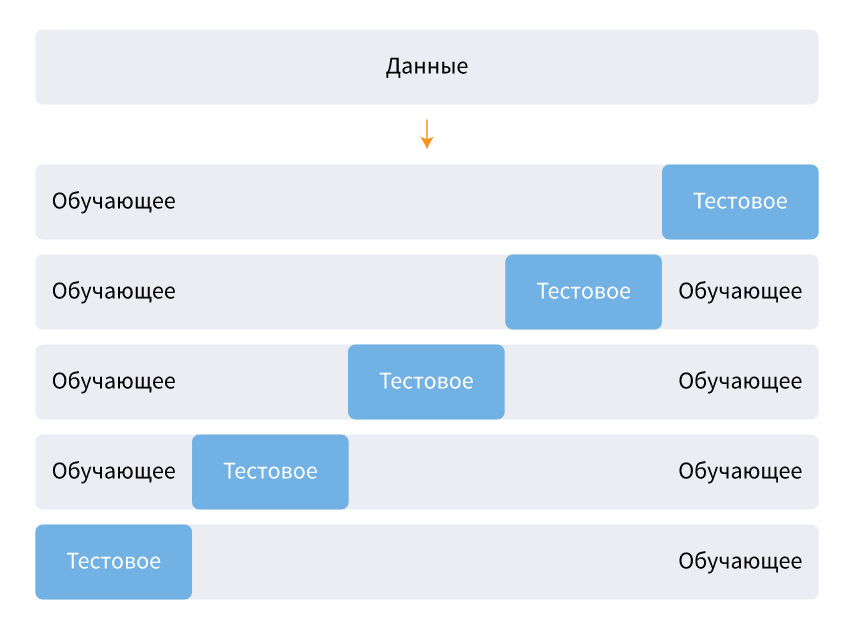![image.png](
  
)

In [ ]:
#
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category= FutureWarning)

In [ ]:
#открываем датасэт
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
#приводим Survived к типу интеджер
target = train['Survived'].astype(int)
test_ids = test['PassengerId']

In [ ]:
#удаляем колонки PassengerId, Survived
train1 = train.drop(['PassengerId', 'Survived'], axis = 1)
test1 = test.drop('PassengerId', axis=1)

In [ ]:
#соединяем данные 
data1 = pd.concat([train1, test1], axis= 0).reset_index(drop= True)
data1.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
#удаляем колонки, которые не имеют смысла 
# axis = 1 - значит применяем вычсления построчно 
# inplace= True - вносим изменения в датафрэйм
data1.drop(['Name', 'Ticket', 'Cabin'], axis= 1, inplace= True)
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Sex       1309 non-null   object 
 2   Age       1046 non-null   float64
 3   SibSp     1309 non-null   int64  
 4   Parch     1309 non-null   int64  
 5   Fare      1308 non-null   float64
 6   Embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 71.7+ KB


## Посмотрим коррелляции между фичами

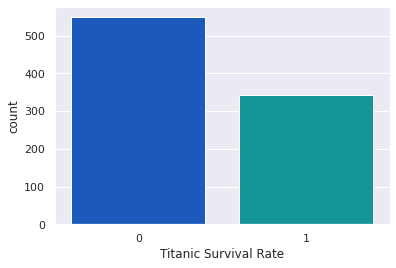

In [ ]:
#построим график, чтобы посмотреть сколько отношение невыживших к выжившим 
sns.countplot(x = target, palette= 'winter')
plt.xlabel('Titanic Survival Rate');

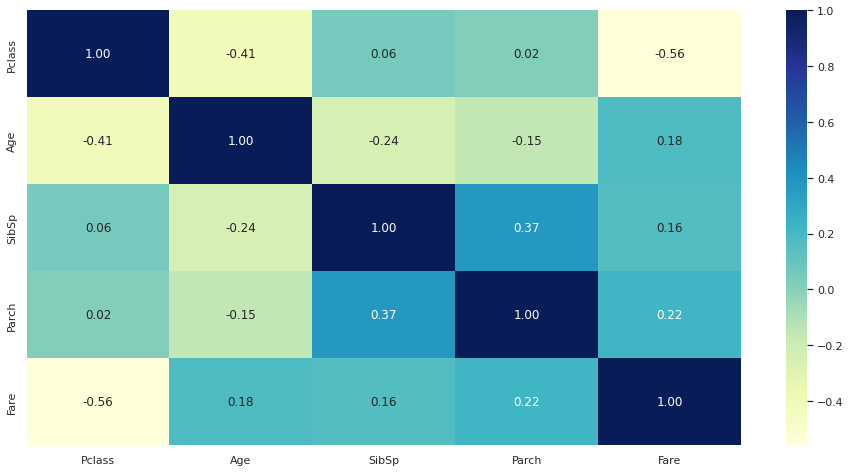

In [ ]:
#матрица корреляции
plt.figure(figsize= (16, 8))
sns.heatmap(data1.corr(), annot = True, cmap= 'YlGnBu', fmt= '.2f');

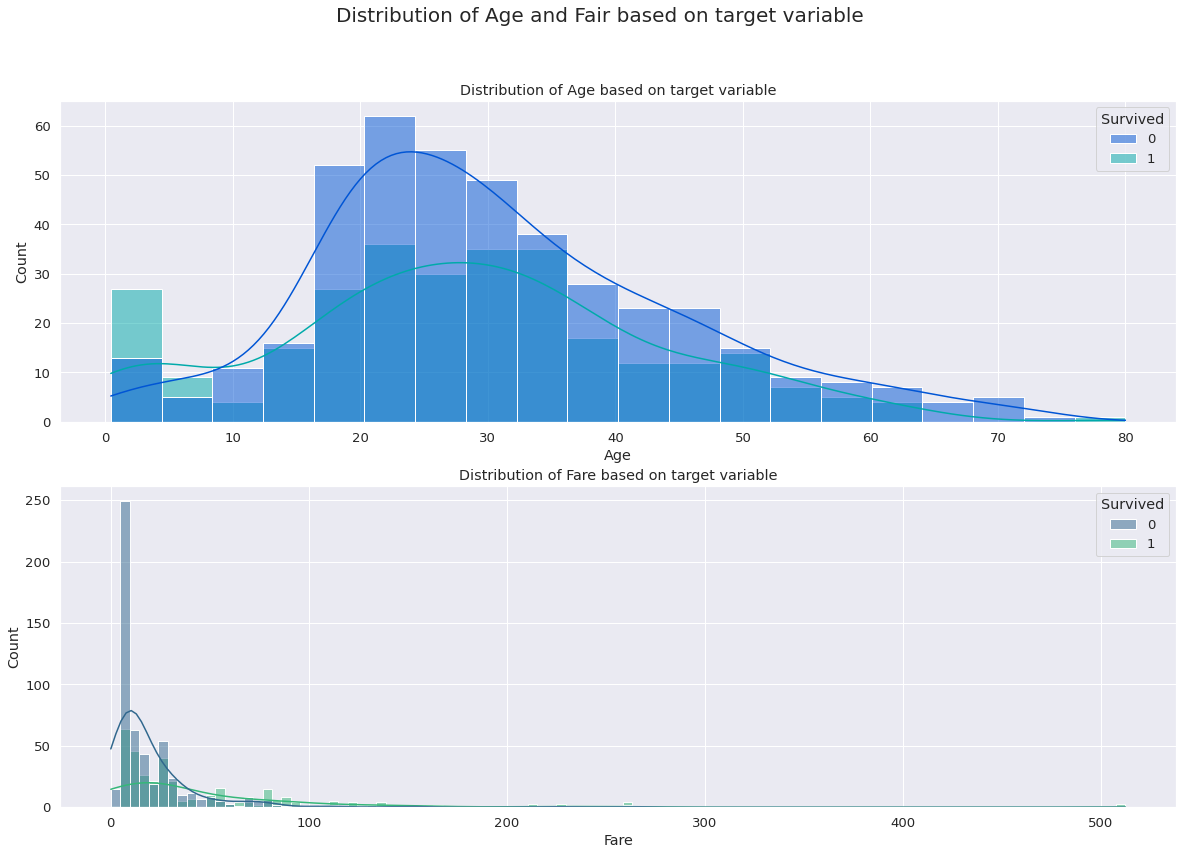

In [ ]:
#посмотрим как возраст коррелируют с ценой 

sns.set_context('notebook', font_scale= 1.2)
fig, ax = plt.subplots(2, figsize = (20, 13))
plt.suptitle('Distribution of Age and Fair based on target variable', fontsize = 20)

# I am using the training dataset only to plot these as we don't have target variable in our test dataset
ax1 = sns.histplot(x ='Age', data = train, hue= 'Survived', kde= True, ax= ax[0], palette= 'winter')
ax1.set(xlabel = 'Age', title='Distribution of Age based on target variable')
ax2 = sns.histplot(x ='Fare', data = train, hue='Survived', kde= True, ax= ax[1], palette= 'viridis')
ax2.set(xlabel = 'Fare', title= 'Distribution of Fare based on target variable')
plt. show()

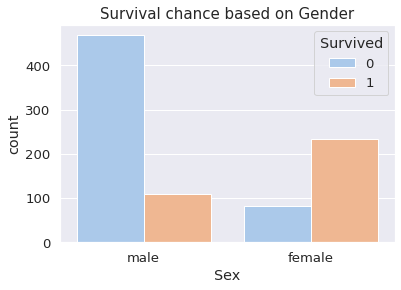

In [ ]:
#посмотрим выжиываемость в зависимости от пола 
sns.countplot(x = 'Sex', data= train, hue= 'Survived', palette= 'pastel')
plt.title('Survival chance based on Gender', fontsize = 15);

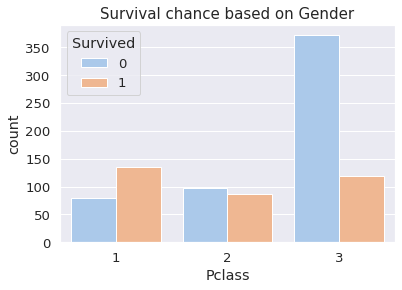

In [ ]:
#посмотрим выжиываемость в зависимости от класса 
sns.countplot(x = 'Pclass', data= train, hue= 'Survived', palette= 'pastel')
plt.title('Survival chance based on Gender', fontsize = 15);

## Заполним пропущенные значения 


In [ ]:
#заполняем пропущенные значения с помощью knn
def knn_impute(df, na_target):
  df = df.copy()

  #берем колонки с числовыми значениеями 
  numeric_df = df.select_dtypes(np.number)
  #колонки, где нет пропущенные значения 
  non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
  #выбрали колонку на которой будем предсказывать 
  y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]

  X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
  X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
  
  knn = KNeighborsRegressor()
  knn.fit(X_train, y_train)

  y_pred = knn.predict(X_test)
  
  df.loc[df[na_target].isna() == True, na_target] = y_pred
  
  return df

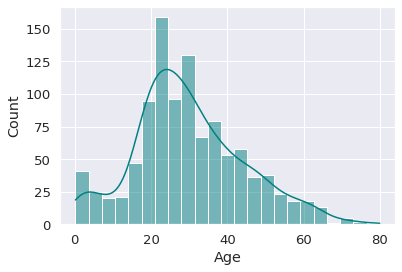

In [ ]:
#распределение по возрасту
sns.histplot(data1['Age'], color= 'teal', kde= True);

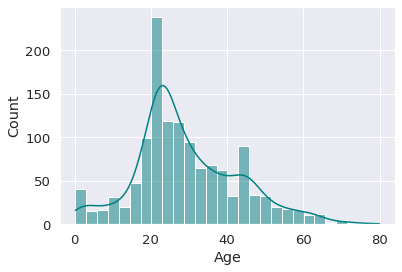

In [ ]:
#применяем алгоритм к возрасту 

data2 = knn_impute(data1, 'Age')
#распределение по возрасту
sns.histplot(data2['Age'], color= 'teal', kde= True);

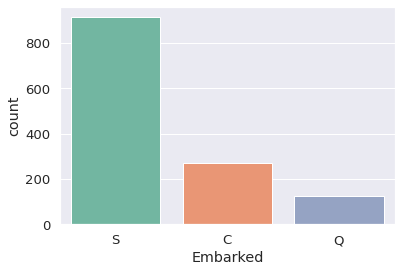

In [ ]:
#посмотрим пропуски по причалам 
sns.countplot(x = data2['Embarked'], palette = 'Set2');

In [ ]:
# заполним пропуски этим значением (inplace = True - заполнить на месте)
data2['Embarked'].fillna('S', inplace = True)

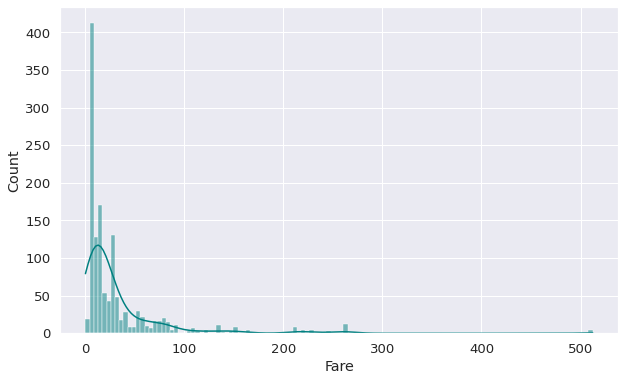

In [ ]:
#посмотрим  значения по цене
plt.figure(figsize = (10,6))
sns.histplot(data2['Fare'], color = 'Teal', kde = True)

In [ ]:
data2['Fare'].fillna(data1['Fare'].median(), inplace= True)

In [ ]:
#посмотрим количество пропущенных значений
data2.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

##Encoding

In [ ]:
data3 = data2.copy()
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Sex       1309 non-null   object 
 2   Age       1309 non-null   float64
 3   SibSp     1309 non-null   int64  
 4   Parch     1309 non-null   int64  
 5   Fare      1309 non-null   float64
 6   Embarked  1309 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 71.7+ KB


In [ ]:
#заменим пол на 0 и 1
d = {'male' : 0, 'female' : 1}
data3['Sex']= data3['Sex'].map(d)
data3.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,7.2500,S
1,1,1,38.0,1,0,71.2833,C
2,3,1,26.0,0,0,7.9250,S
3,1,1,35.0,1,0,53.1000,S
4,3,0,35.0,0,0,8.0500,S


In [ ]:
#заменим Embarked на числовые значения 
data3 = pd.get_dummies(data3, columns = ['Embarked'])
data3.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,3,0,22.0,1,0,7.2500,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,0
2,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,3,0,35.0,0,0,8.0500,0,0,1


In [ ]:
#стандартизиурем данные 
sc = StandardScaler()
data3[['Age', 'For']] = sc.fit_transform(data3[['Age', 'Fare']])
data3.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,For
0,3,0,-0.534915,1,0,7.2500,0,0,1,-0.503291
1,1,1,0.639651,1,0,71.2833,1,0,0,0.734744
2,3,1,-0.241273,0,0,7.9250,0,0,1,-0.490240
3,1,1,0.419420,1,0,53.1000,0,0,1,0.383183
4,3,0,0.419420,0,0,8.0500,0,0,1,-0.487824


## Feature engineering

In [ ]:
# если у человека есть SibSp или Parch 
data3['Family'] = np.where(data3['SibSp'] + data3['Parch'] > 0, 1, 0)
# data3.drop(['SibSp', 'Parch'], axis= 1, inplace= True)
data3.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,For,Family
0,3,0,-0.534915,1,0,7.2500,0,0,1,-0.503291,1
1,1,1,0.639651,1,0,71.2833,1,0,0,0.734744,1
2,3,1,-0.241273,0,0,7.9250,0,0,1,-0.490240,0
3,1,1,0.419420,1,0,53.1000,0,0,1,0.383183,1
4,3,0,0.419420,0,0,8.0500,0,0,1,-0.487824,0


In [ ]:
train_final = data3.loc[:train.index.max(), :].copy()
test_final = data3.loc[train.index.max() + 1:, :].reset_index(drop=True).copy()
target = target.astype(int)

## Тренируем датасэт

In [ ]:
# словарь с моделями которые будем использовать 
models = {
'xgboost' : XGBClassifier(),
'cat boots' : CatBoostClassifier(verbose=0),
'lightgbm' : LGBMClassifier(),
'gradient boosting' : GradientBoostingClassifier(),
'random forest' : RandomForestClassifier(),
'logistic regression': LogisticRegression(),
'naive bayes': GaussianNB()
}

In [ ]:
for name, model in models.items():
  model.fit(train_final, target)
  # print(f'{name} trained')

In [ ]:
results = {}
kf = KFold(n_splits= 10)

for name, model in models.items():
  result = cross_val_score(model, train_final, target, scoring = 'roc_auc', cv= kf)
  results[name] = np.mean(result)

In [ ]:
# смотрим на значение ошибки roc_auc для каждой модели
for name, result in results.items():
  print("-------\n" + name)
  print(f'ROC score: {round(result, 3)}')

-------
xgboost
ROC score: 0.866
-------
cat boots
ROC score: 0.87
-------
lightgbm
ROC score: 0.869
-------
gradient boosting
ROC score: 0.87
-------
random forest
ROC score: 0.86
-------
logistic regression
ROC score: 0.854
-------
naive bayes
ROC score: 0.81


In [ ]:
results_df = pd.DataFrame(results, index=range(0,1)).T.rename(columns = {0: 'ROC Score'}).sort_values('ROC Score', ascending = False)
results_df

,ROC Score
cat boots,0.870486
gradient boosting,0.870304
lightgbm,0.868955
xgboost,0.865935
random forest,0.859812
logistic regression,0.853849
naive bayes,0.809907


Text(0.5, 0, 'Model')

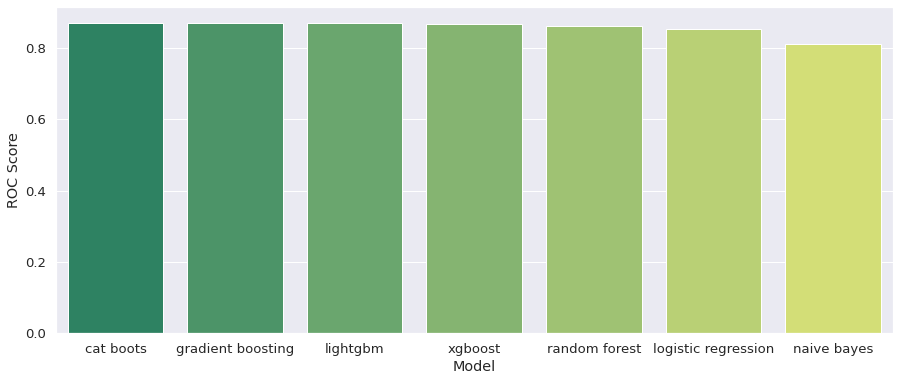

In [ ]:
plt.figure(figsize = (15, 6))
sns.barplot(x= results_df.index, y = results_df['ROC Score'], palette = 'summer')
plt. xlabel('Model')

##Optuna

автоматизированный поиск оптимальных гиперпараметров для моделей машинного обучения

In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.5 MB/s eta 0:00:00


In [ ]:
import optuna

Оптимизируем catboost

In [ ]:
def catboost_objective(trial):
  #learning_rate - дискретность шага (с какой скоростью мы спускаемся)
  #если с большой скоростью - то можем пропустить значения 
  #если с маленькой - можем в минимальных значениях засесть 
  learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5)
  #глубина деревьев 
  depth = trial.suggest_int('depth', 3, 10)
  #количество деревьев
  n_estimators = trial.suggest_int('n_estimators', 50, 600)
  
  # строим модель catboost
  model = CatBoostClassifier(
    learning_rate= learning_rate,
    depth= depth,
    n_estimators= n_estimators,
    verbose = 0
  ) 
  # тренируем модель 
  model.fit(train_final, target)
  
  cv_score = cross_val_score(model, train_final, target, scoring= 'roc_auc', cv= kf)
  
  return np.mean(cv_score)
  
study = optuna.create_study(direction= 'maximize')
# n_trials количество попыток для подбора гиперпараметров
study.optimize(catboost_objective, n_trials= 100)

[I 2023-01-24 21:25:49,090] A new study created in memory with name: no-name-aba7f45f-57e0-4dad-99d3-1338120dff08
[I 2023-01-24 21:25:50,878] Trial 0 finished with value: 0.8704289843082729 and parameters: {'learning_rate': 0.4354631715698019, 'depth': 6, 'n_estimators': 112}. Best is trial 0 with value: 0.8704289843082729.
[I 2023-01-24 21:26:55,957] Trial 1 finished with value: 0.8655109849199445 and parameters: {'learning_rate': 0.23159064721468361, 'depth': 10, 'n_estimators': 596}. Best is trial 0 with value: 0.8704289843082729.
[I 2023-01-24 21:27:00,213] Trial 2 finished with value: 0.8705782236803806 and parameters: {'learning_rate': 0.1604962451174002, 'depth': 6, 'n_estimators': 301}. Best is trial 2 with value: 0.8705782236803806.
[I 2023-01-24 21:27:06,669] Trial 3 finished with value: 0.8642164602973323 and parameters: {'learning_rate': 0.2965618478058783, 'depth': 5, 'n_estimators': 592}. Best is trial 2 with value: 0.8705782236803806.
[I 2023-01-24 21:27:17,708] Trial 4 

In [ ]:
# study.best_params - посмотреть лучшие параметры 
study.best_params

{'learning_rate': 0.1500276711863258, 'depth': 4, 'n_estimators': 332}

In [ ]:
# лучшее испытание в исследовании
study.best_trial

FrozenTrial(number=51, state=TrialState.COMPLETE, values=[0.879372766867287], datetime_start=datetime.datetime(2023, 1, 24, 21, 32, 25, 542924), datetime_complete=datetime.datetime(2023, 1, 24, 21, 32, 28, 691927), params={'learning_rate': 0.1500276711863258, 'depth': 4, 'n_estimators': 332}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.5, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'n_estimators': IntDistribution(high=600, log=False, low=50, step=1)}, trial_id=51, value=None)

In [ ]:
study.best_value

0.879372766867287

In [ ]:

catboost_params = {
    'learning_rate': 0.29755543367129206, 'depth': 3, 'n_estimators': 225, 'verbose': 0

}

In [ ]:
cb = CatBoostClassifier(**catboost_params)
cb.fit(train_final, target)
pred_cb = cb.predict(test_final)

In [ ]:
submission = pd.DataFrame(test_ids, index= None)
submission['Survived'] = pred_cb
submission.to_csv('submission.csv', index= None)